## Description:

    Use DeSeq2 to identify differential abundance among treatments
    Following  Ashley's succ-C notebook


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.0.0’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.4.0’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.2’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [6]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)

physeq.plant = subset_samples(physeq.Full, Plant != "BARE")

## Create DeSeq2 object

# Function generating Ntreatment log2fold change figure

In [7]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Rep + Treatment)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.obj %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    return(d)
}

# Function to trim physeq object to just plant to include in Deseq analysis
deseq_prune = function(physeq.obj, plant) {
    physeq.md = sample_data(physeq.obj)
   p = subset_samples(physeq.obj, Plant == plant)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}


In [8]:
%%R
sample_data(physeq.plant)$Plant %>% unique

 [1] 75-062 Oh7B   SETFA  MS71   ERATE  FAGES  B73    AMAPO  B97    GLYMA 
[11] H99    Il14H  SORBI  SORSUD ELCOR  ABUTH  Ki3    HELAN  Tx303  Hp301 
[21] ECHCG  Mo18  
22 Levels: 75-062 ABUTH AMAPO B73 B97 ECHCG ELCOR ERATE FAGES GLYMA ... Tx303


In [9]:
%%R
t = subset_samples(physeq.plant, Plant == "Tx303")
t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 8 samples ]
sample_data() Sample Data:       [ 8 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## loop through sampling dates to compare enrichment in rhizosphere to bare soil

In [10]:
%%R -w 1200 -h 600

Sd = sample_data(physeq.plant)
Plants = levels(Sd$Plant)

df_all = data.frame()
df_plant = data.frame()
    
for (plant in Plants) {
        
        
        #Trim physeq object by to day-plant combo 
        physeq.p = deseq_prune(physeq.plant, plant)
        
        
        #convert to deseq using function above
        DF = get_Ps(physeq.p) 
   
        DF = data.frame(DF)
        DF$Plant = plant
        df_plant = rbind(df_plant, DF)     
    }


df_all = df_plant 


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [11]:
%%R
df_all %>% tail


        baseMean log2FoldChange    pvalue      padj      OTU    Rank1
97473 14.6176801     0.18386422 0.7747214 0.9999423  OTU.126 Bacteria
97474  5.5855056     0.68634767 0.3685042 0.9999423  OTU.235 Bacteria
97475  0.6626947     0.83113026 0.2609280 0.9999423 OTU.4437 Bacteria
97476  0.2295764     0.01736376 0.9784306 0.9999423 OTU.6063 Bacteria
97477  0.7338113    -0.62823365 0.4143697 0.9999423 OTU.3516 Bacteria
97478  2.9251250     0.11950912 0.8873878 0.9999423 OTU.7969 Bacteria
            Rank2      Rank3         Rank4     Rank5                Rank6 Rank7
97473 Nitrospirae Nitrospira Nitrospirales 0319-6A21 uncultured_bacterium  <NA>
97474 Nitrospirae Nitrospira Nitrospirales 0319-6A21 uncultured_bacterium  <NA>
97475 Nitrospirae Nitrospira Nitrospirales 0319-6A21 uncultured_bacterium  <NA>
97476 Nitrospirae Nitrospira          <NA>      <NA>                 <NA>  <NA>
97477 Nitrospirae Nitrospira Nitrospirales 0319-6A21 uncultured_bacterium  <NA>
97478 Nitrospirae Nitrospira N

In [12]:
%%R
df_all$padj %>% range %>% print
df_all %>% dim %>% print
df_all$padj%>% unique %>% length

[1] NA NA
[1] 97478    14
[1] 439


In [13]:
%%R -i workDir


write.csv(df_all, file = "/home/bryan/RhizCG/figures/Ntreat-l2f.csv", row.names = FALSE, sep = ",")

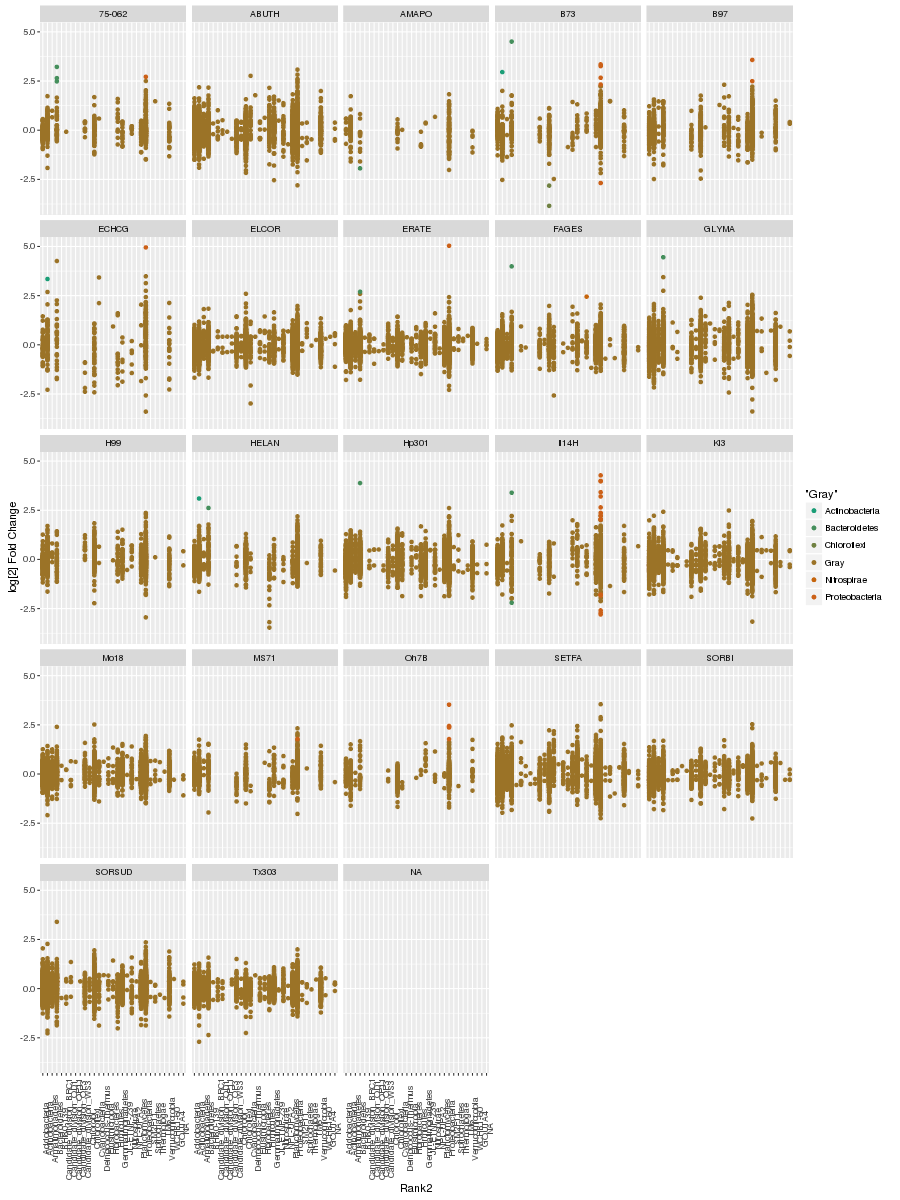

In [14]:
%%R -w 900 -h 1200

colourCount = length(unique(df_all$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

df.adj = df_all[!is.na(df_all$padj),]
df.sig = df_all[df_all$padj < .05,]
df.ns = df_all[df_all$padj >= .05,]

p = ggplot(df_all)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Plant)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p    
    

In [15]:
%%R
##saving figure
pdf(file = "/home/bryan/RhizCG/figures/NposEnriched_byPlant.pdf", width=9, height=8)
print(p)
dev.off()

png 
  2 


In [16]:
%%R
df.sig

            baseMean log2FoldChange       pvalue         padj       OTU
NA                NA             NA           NA           NA      <NA>
NA.1              NA             NA           NA           NA      <NA>
NA.2              NA             NA           NA           NA      <NA>
NA.3              NA             NA           NA           NA      <NA>
NA.4              NA             NA           NA           NA      <NA>
NA.5              NA             NA           NA           NA      <NA>
NA.6              NA             NA           NA           NA      <NA>
NA.7              NA             NA           NA           NA      <NA>
NA.8              NA             NA           NA           NA      <NA>
NA.9              NA             NA           NA           NA      <NA>
NA.10             NA             NA           NA           NA      <NA>
NA.11             NA             NA           NA           NA      <NA>
NA.12             NA             NA           NA           NA   

In [24]:
%%R
## Check analysis by plant against whole rhizosphere dataset
 
    diagdds = phyloseq_to_deseq2(physeq.plant, ~Plant + Treatment)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    

In [25]:
%%R
summary(r)
    


out of 4981 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 194, 3.9% 
LFC < 0 (down)   : 79, 1.6% 
outliers [1]     : 30, 0.6% 
low counts [2]   : 1226, 25% 
(mean count < 0.4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [26]:
%%R
df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

   baseMean log2FoldChange      pvalue       padj      OTU    Rank1
1 0.2060284      0.1045902 0.724324141         NA OTU.5899 Bacteria
2 2.2028300     -0.3634532 0.053478586 0.29202635 OTU.8680 Bacteria
3 0.6566916      0.1359641 0.567021500 0.83076229 OTU.2666 Bacteria
4 6.2462284     -0.3482049 0.007014547 0.09778297  OTU.323 Bacteria
5 0.8990901      0.1460809 0.517823597 0.80370537 OTU.7636 Bacteria
6 1.0984479     -0.2174381 0.400943904 0.72529426 OTU.1030 Bacteria
           Rank2               Rank3                Rank4                Rank5
1  Acidobacteria               32-21 uncultured_bacterium                 <NA>
2  Acidobacteria          Holophagae              Sva0725                 <NA>
3  Acidobacteria          Holophagae              Sva0725 uncultured_bacterium
4  Acidobacteria          Holophagae              Sva0725                 <NA>
5  Acidobacteria          Holophagae              Sva0725                 <NA>
6 Proteobacteria Deltaproteobacteria    Desulfobac

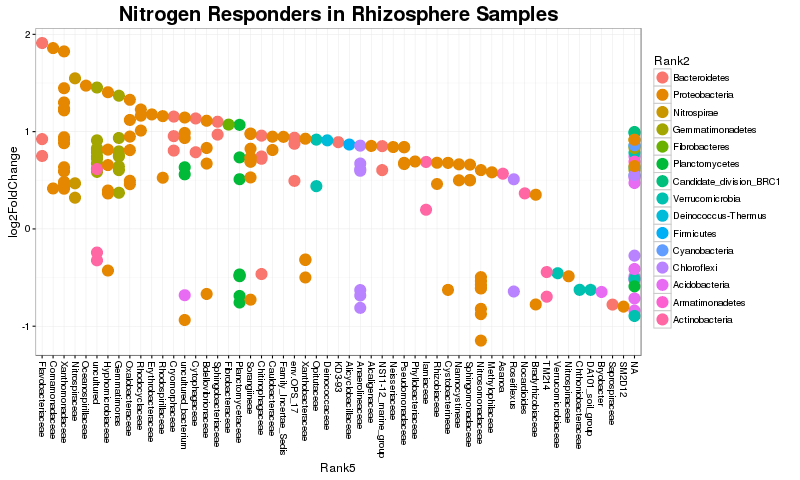

In [27]:
%%R -w 800
sigtab = d[d$padj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + 
    geom_point(size=5) + 
    ggtitle("Nitrogen Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [28]:
%%R
sigtab$OTU %>% unique %>% length

[1] 197


In [30]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/Ntreatment_AllRhizospheres.pdf", height = 6, width = 8)
print(p)
dev.off()

png 
  2 


## Analyze against inorganic N

In [32]:
%%R
## Check analysis by plant against whole rhizosphere dataset
physeq.N = subset_samples(physeq.plant, !is.na(InorganicN)) 

    diagdds = phyloseq_to_deseq2(physeq.N, ~Plant + InorganicN)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

    r = results(diagdds, independentFiltering = TRUE, parallel = TRUE)
    

In [33]:
%%R
summary(r)
    


out of 4980 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 47, 0.94% 
LFC < 0 (down)   : 52, 1% 
outliers [1]     : 0, 0% 
low counts [2]   : 3984, 80% 
(mean count < 4.4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [34]:
%%R
df = as.data.frame(r[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

   baseMean log2FoldChange     pvalue      padj      OTU    Rank1
1 0.2708800    0.001538003 0.92368458        NA OTU.5899 Bacteria
2 2.7684588   -0.027145608 0.12401076        NA OTU.8680 Bacteria
3 0.8922102    0.005646274 0.75932390        NA OTU.2666 Bacteria
4 9.0957488   -0.031212567 0.02891308 0.1714133  OTU.323 Bacteria
5 1.3442506    0.010466075 0.56091629        NA OTU.7636 Bacteria
6 1.4396294   -0.015523902 0.40164210        NA OTU.1030 Bacteria
           Rank2               Rank3                Rank4                Rank5
1  Acidobacteria               32-21 uncultured_bacterium                 <NA>
2  Acidobacteria          Holophagae              Sva0725                 <NA>
3  Acidobacteria          Holophagae              Sva0725 uncultured_bacterium
4  Acidobacteria          Holophagae              Sva0725                 <NA>
5  Acidobacteria          Holophagae              Sva0725                 <NA>
6 Proteobacteria Deltaproteobacteria    Desulfobacterales       

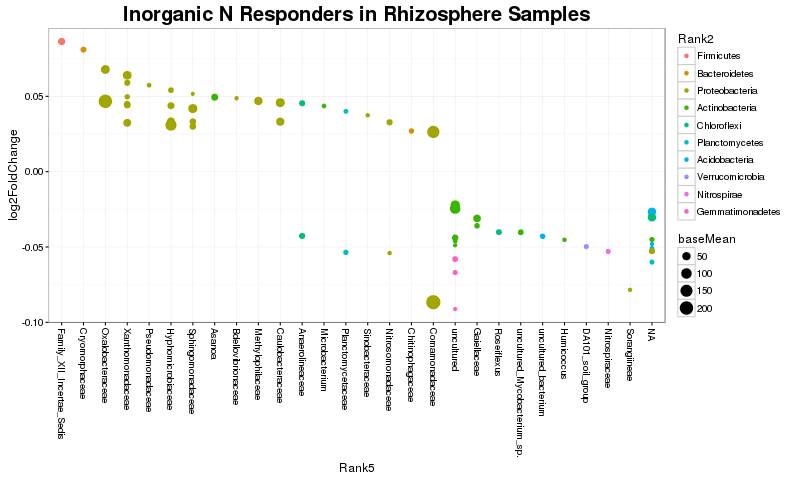

In [37]:
%%R -w 800
sigtab = d[d$padj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))

x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))

 

p = ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() + 
    ggtitle("Inorganic N Responders in Rhizosphere Samples") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5),
    plot.title = element_text(face="bold", size=20))
       
p
    

In [ ]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/InorganicN_AllRhizospheres.pdf", height = 6, width = 8)
print(p)
dev.off()